In [6]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [7]:
using Random
using FilePathsBase;
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

include("src/utils.jl")
include("src/expo_environment.jl")
include("src/raycaster.jl");
include("src/path_planning.jl");

**Choose an environment**

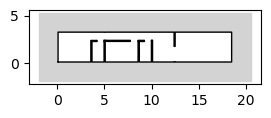

In [9]:
env = load_env(2010; path=p"data/HouseExpo_json");
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);

**Choose a path**

In [5]:
paths = []
for _=1:20
    path = get_random_path(env, PlannerParams(2000, 1., .01, 1000, 1.0, 0.2); simplify=true)
    push!(paths, path)
end

# ----------
for i=1:5:20
    _, axs = plt.subplots(1,4, figsize=(15,3)); 
    for ax in axs ax.set_aspect(1.); ax.axis("off"); end
    for j=0:3
        ax = axs[j+1]
        x, = decompose(paths[i+j])

        draw_env!(env,ax=ax);
        ax.plot(x[:,1],x[:,2], c="C0", marker=".", alpha=.4, zorder=4);
        ax.set_title("paths[ $(i+j) ]")
    end
end

UndefVarError: UndefVarError: env not defined

**Collect measurements along the path**

Our SLAM model will be structured and indexed as follows:

```julia
        u[1]    u[1]    ...
         |       |
p[1] -- p[2] -- p[3] -- ...
 |       |       |
z[1]    z[2]    z[3]    ...
```

The sensor measurements are given by $z_t = g(x_t, \theta_t, \text{env})$.
For $u_t=(s_t, d\theta_t)$ the pose update $(x_{t},\theta_t) = f(x_{t-1}, \theta_{t-1}, u_{t})$ is given by:

- $\theta_t = \theta_{t-1} + d\theta_t$
- $x_{t} = x_{t-1} + s_t\cdot e^{i\theta_t}$, that means $\theta_t = \theta(x_t - x_{t-1})$



**However** the decomposed path below is indexed as follows:

- $\theta_t = \theta( x_{t+1} - x_{t})$
- $\theta_t = \theta_{t-1} + d\theta_{t-1}$

**Thus** we'll adjust the indexing to make it consistent with the models in the other notebooks.

In [8]:
i = 18
x, hd, s, dhd = decompose(paths[i])

# Adjustments as described above
hd  = [hd[1]; hd...];
dhd = [0; dhd...];

println(size(x), size(hd), size(s), size(dhd))

(13, 2)(13,)(12,)(12,)


In [18]:
function pseudo_lidar(x, hd, fov, n, env; max_val=Inf)
    a = fov == 180 ? angles(fov, n+1)[1:end-1] : angles(fov, n)
    da = a[2] - a[1]
    a .+= da/2
    rays = lightcone(a .+ hd)
    z = cast(rays, x, env.segs; max_val=max_val)
    return z,a
end;

In [30]:
T = length(hd)

fov = 180
n = 100
max_val = Inf

zs = []
as = []
xs = [] 

for t=1:T
    z, a = pseudo_lidar(x[t,:], hd[t], fov, n, env; max_val=max_val)
    push!(zs, z)
    push!(as, a)
    push!(xs, x[t,:])
end

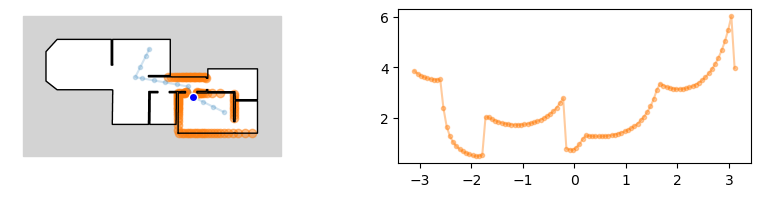

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc7902dc710>

In [24]:
t=rand(1:length(zs))
fig, axs = plt.subplots(1,2,figsize=(10,2)); 
axs[1].set_aspect(1); axs[1].axis("off");
draw_env!(env; ax=axs[1])
y = zs[t] .* [cos.(as[t] .+ hd[t]) sin.(as[t] .+ hd[t])]
y .+= x[t,:]'

axs[1].scatter(y[:,1],y[:,2], c="C1", alpha=0.5)
axs[1].scatter(x[t,1], x[t,2], c="b", edgecolor="w", marker="o", alpha=1., zorder=10)
axs[1].plot(x[:,1], x[:,2], c="C0", marker=".", alpha=.2, zorder=9)
axs[2].plot(as[t], zs[t], c="C1", marker=".", alpha=.4)

**Save the measurements**

In [31]:
save("example_sensor_data.jld", 
        "x", xs, 
        "hd", hd, 
        "s", s, 
        "dhd", dhd, 
        "z",zs,
        "a",as, 
        "fov", fov, 
        "n", n, 
        "max_val", max_val, 
        "env_id", env.id)

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/AmppF/src/loadsave.jl:210
